# Smoothness
---
The purpose of this notebook is to compute the smoothness of several model parameterization outputs w.r.t. some generated teacher outputs.

## Notebook configuration
Configure several notebook configuration settings.

In [1]:
# Disable some warnings

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

# Use full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Libraries / Packages
Import several useful packages for the notebook and configure some extra options.

In [2]:
# Miscellaneous libraries
import os
import time
import random
import itertools
import numpy as np
import pandas as pd
import networkx as nx

from tqdm.notebook import tqdm
from collections import defaultdict, Counter

# Setup some options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100


# Visualization
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

## Fetching data to analyze
---
Fetch all the generated `smoothness` csv files generated and analyze them.

In [3]:
!ls "../data/synthetic/erdos_renyi"

N100_n100_p0.1_1624367054 N200_n100_p0.1_1624514787
N100_n30_p0.1_1624230420  N300_n100_p0.1_1624629108


In [4]:
!ls "../data/synthetic/erdos_renyi/N300_n100_p0.1_1624629108/teacher_outputs/regression/GIN"

hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1
hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.3_upper0.3
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1
num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-1.0_upper1.0


In [5]:
!ls "../data/synthetic/erdos_renyi/N300_n100_p0.1_1624629108/teacher_outputs/regression/GIN/hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1"

1624991428303 1624991428860 1624991429338 1624991429813 1624991430305
1624991428613 1624991429097 1624991429576 1624991430066 1624991430543


In [6]:
teacher_outputs_prefix = \
    "../data/synthetic/erdos_renyi/N300_n100_p0.1_1624629108/" \
    "teacher_outputs/regression/GIN/hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1"

# Retrieve different teacher output configurations
teacher_outputs_filenames = [x for x in os.listdir(teacher_outputs_prefix) if all([c.isdigit() for c in x])]
#teacher_outputs_configs = ['__'.join(x.split('__')[:-1]) for x in teacher_outputs_filenames]
# Make sure to work only with the same teacher configurations
#assert teacher_outputs_configs.count(teacher_outputs_configs[0]) == len(teacher_outputs_configs), \
#    'Please specify teacher configuration! (there are more than one configuration available)'
print(f"Results over {len(teacher_outputs_filenames)} different teacher initializations, using the folowing configuration:")
#print(teacher_outputs_filenames[0][:-15])
print('hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1')

# Retrieve available student models
students = set([
    x for x in os.listdir(f'{teacher_outputs_prefix}/{teacher_outputs_filenames[0]}/student_outputs') if x != '.DS_Store'
])
print()
print(f"Student outputs computed with the following models: {', '.join(students)}")

# Retrieve the different distance matrices used for computing the smoothness
dist_matrices = set()
for teacher_outputs_filename in teacher_outputs_filenames:
    dist_matrix_smoothness = [
        x for x in os.listdir(f'{teacher_outputs_prefix}/{teacher_outputs_filename}/smoothness') 
        if x.endswith('.csv')
    ]
    for dist_matrix in dist_matrix_smoothness:
        dist_matrices.add(dist_matrix.rstrip('.csv'))
print()
print(f"Smoothness computed with the following distance matrices: {', '.join(dist_matrices)}")

Results over 10 different teacher initializations, using the folowing configuration:
hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1

Student outputs computed with the following models: GIN, SGC, ChebNet, SIGN, Baseline, GCN

Smoothness computed with the following distance matrices: WL__hashing__d3_iOnes__hamming__distance_sMaxdegree


---
Fix the `dist matrix` and the `teacher architecture`, and read all the available data for all the available combinations.

In [7]:
DIST_MATRIX = 'WL__hashing__d3_iOnes__hamming__distance_sMaxdegree'

In [8]:
# Define some auxiliary functions for reading the generated smoothness csv files
def readSmoothnessCSV(smoothness_filename):
    '''Auxiliary function to read a generated smoothness csv file.'''
    smoothness_stats = (pd.read_csv(smoothness_filename, header=[0, 1], index_col=[0, 1])
                          .reset_index()
                          .rename(columns={'level_0': 'model', 'level_1': 'model_config'}))
    # Add an extra column with the model type (for later processing)
    #smoothness_stats['model'] = [model] * len(smoothness_stats)
    # Rearange column order for better visualization
    #cols = smoothness_stats.columns.tolist()
    #cols = cols[-1:] + cols[:-1]
    return smoothness_stats #[cols]

In [9]:
# Test method with a sample
sample_filename = f"{teacher_outputs_prefix}/{teacher_outputs_filenames[0]}/smoothness/{DIST_MATRIX}.csv"
sample_smoothness_stats = readSmoothnessCSV(sample_filename)
# Save ordered columns for later processing
#ordered_cols = sample_smoothness_stats.columns.tolist()
sample_smoothness_stats

model                                       model_config  \
                                                                 
0       GCN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
1  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
2       SGC              hidden32_K3__bias0_lower-0.1_upper0.1   
3       GIN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
4   ChebNet  hidden32_blocks3_K2_normalizationSym__bias0_lo...   
5   ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_l...   
6      SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1   
7      SIGN      hidden32_K3_preTrue__bias0_lower-0.1_upper0.1   

                0                                                         1  \
  mean_smoothness std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0    3.879785e+03       5.501219e+03  0.794366     0.688556    3.131604e+03   
1    3.181007e+03       0.000000e+00  0.053658     0.000000             NaN   
2    4.568716e+04       4.155089e+04  2.907617     1.574201    1.049533e+04   
3    2.820619e+04       4.768631e+04  0.940093     0.951029    2.260691e+03   
4    1.423034e+05       1.663948e+05  3.637719     2.603289    3.911479e+03   
5    6.171210e-08       2.317057e-07  4.767826     2.959829    3.897791e-08   
6    2.684471e+05       3.861370e+05  6.061686     4.828189    4.474212e+04   
7    1.052202e+04       1.175478e+04  1.417884     1.237478    3.321402e+03   

                                                          2  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0       4.528593e+02  0.044564     0.003524    3.369386e+03   
1                NaN       NaN          NaN             NaN   
2       9.448874e+03  0.160034     0.113614    7.512961e+03   
3       2.195290e+02  0.075607     0.010245    3.137439e+03   
4       2.820617e+02  0.033286     0.011146    3.838724e+03   
5       2.792950e-08  0.132334     0.000243    3.323151e-08   
6       1.006750e+05  0.281351     0.306995    2.631923e+04   
7       6.398169e+02  0.039595     0.010488    3.603710e+03   

                                                          3  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0       3.233601e+01  0.038874     0.002670    3.380428e+03   
1                NaN       NaN          NaN             NaN   
2       6.909797e+03  0.122340     0.098075    5.459331e+03   
3       6.788975e+02  0.039297     0.017840    3.764057e+03   
4       2.217277e+02  0.024012     0.007558    3.817567e+03   
5       1.884334e-08  0.132282     0.000151    3.525386e-08   
6       5.493925e+04  0.219631     0.219715    1.428728e+04   
7       1.150131e+02  0.031287     0.005493    3.647263e+03   

                                                          4  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0       3.210416e+01  0.035200     0.003278    3.404485e+03   
1                NaN       NaN          NaN             NaN   
2       4.355781e+03  0.092939     0.078833    4.247059e+03   
3       2.533562e+02  0.024857     0.005317    3.913941e+03   
4       2.024872e+02  0.024560     0.005821    3.817887e+03   
5       2.070276e-08  0.132401     0.000281    3.300767e-08   
6       2.417810e+04  0.169666     0.135884    8.051558e+03   
7       7.963786e+01  0.027516     0.001874    3.673772e+03   

                                                          5  \
  std_dev_smoothness mean_rmse std_dev_rmse mean_smoothness   
0       5.905717e+01  0.032479     0.003731    3.459474e+03   
1                NaN       NaN          NaN             NaN   
2       2.617267e+03  0.074177     0.057641    3.591798e+03   
3       9.000135e+01  0.025151     0.004544    3.914352e+03   
4       1.972306e+02  0.024799     0.006398    3.764599e+03   
5       1.972151e-08  0.132410     0.000250    3.135775e-08   
6       9.066328e+03  0.128868     0.075354    5.368822e+03   
7       5.128074e+01  0.026450     0.001945    3.703961e+03   

                              

In [11]:
# Gather all results for a given fixed teacher parameterization and a fixed distance matrix for computing the smoothness
smoothness_stats = pd.DataFrame()
for teacher_outputs_filename in tqdm(teacher_outputs_filenames):
    student_outputs_filename = \
        f"{teacher_outputs_prefix}/{teacher_outputs_filename}/smoothness/{DIST_MATRIX}.csv"
    smoothness_stats = smoothness_stats.append(
        readSmoothnessCSV(student_outputs_filename), ignore_index=True)
#smoothness_stats = smoothness_stats[ordered_cols]
smoothness_stats

  0%|          | 0/10 [00:00<?, ?it/s]

model                                       model_config  \
                                                                  
0        GCN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
1   Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
2        SGC              hidden32_K3__bias0_lower-0.1_upper0.1   
3        GIN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
4    ChebNet  hidden32_blocks3_K2_normalizationSym__bias0_lo...   
5    ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_l...   
6       SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1   
7       SIGN      hidden32_K3_preTrue__bias0_lower-0.1_upper0.1   
8        GCN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
9   Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
10       SGC              hidden32_K3__bias0_lower-0.1_upper0.1   
11       GIN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
12   ChebNet  hidden32_blocks3_K2_normalizationSym__bias0_lo...   
13   ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_l...   
14      SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1   
15      SIGN      hidden32_K3_preTrue__bias0_lower-0.1_upper0.1   
16       GCN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
17  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
18       SGC              hidden32_K3__bias0_lower-0.1_upper0.1   
19       GIN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
20   ChebNet  hidden32_blocks3_K2_normalizationSym__bias0_lo...   
21   ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_l...   
22      SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1   
23      SIGN      hidden32_K3_preTrue__bias0_lower-0.1_upper0.1   
24       GCN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
25  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
26       SGC              hidden32_K3__bias0_lower-0.1_upper0.1   
27       GIN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
28   ChebNet  hidden32_blocks3_K2_normalizationSym__bias0_lo...   
29   ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_l...   
30      SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1   
31      SIGN      hidden32_K3_preTrue__bias0_lower-0.1_upper0.1   
32       GCN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
33  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
34       SGC              hidden32_K3__bias0_lower-0.1_upper0.1   
35       GIN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
36   ChebNet  hidden32_blocks3_K2_normalizationSym__bias0_lo...   
37   ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_l...   
38      SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1   
39      SIGN      hidden32_K3_preTrue__bias0_lower-0.1_upper0.1   
40       GCN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
41  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
42       SGC              hidden32_K3__bias0_lower-0.1_upper0.1   
43       GIN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
44   ChebNet  hidden32_blocks3_K2_normalizationSym__bias0_lo...   
45   ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_l...   
46      SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1   
47      SIGN      hidden32_K3_preTrue__bias0_lower-0.1_upper0.1   
48       GCN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
49  Baseline  WL__hashing__d3_iOnes__hamming__distance_sMaxd...   
50       SGC              hidden32_K3__bias0_lower-0.1_upper0.1   
51       GIN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
52   ChebNet  hidden32_blocks3_K2_normalizationSym__bias0_lo...   
53   ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_l...   
54      SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1   
55      SIGN      hidden32_K3_preTrue__bias0_lower-0.1_upper0.1   
56       GCN  hidden32_blocks3_residualFalse_jkFalse__bias0_...   
57  Baseline  WL__hashing__d3_iOnes__hamming__distance

Average the results throughout the different teacher initializations.

In [12]:
#warnings.filterwarnings('ignore', category='PerformanceWarning')

smoothness_stats_avg = smoothness_stats.groupby(['model', 'model_config']).mean()
smoothness_stats_avg

/Users/berges/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


0  \
                                                            mean_smoothness   
model    model_config                                                         
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...    9.101816e+04   
ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_lo...    1.058794e-07   
         hidden32_blocks3_K2_normalizationSym__bias0_low...    1.495400e+05   
GCN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...    9.280729e+03   
GIN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...    1.402842e+04   
SGC      hidden32_K3__bias0_lower-0.1_upper0.1                 5.176648e+04   
SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1        1.632826e+05   
         hidden32_K3_preTrue__bias0_lower-0.1_upper0.1         9.571577e+03   

                                                                                \
                                                            std_dev_smoothness   
model    model_config                                                            
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...       0.000000e+00   
ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_lo...       2.591377e-07   
         hidden32_blocks3_K2_normalizationSym__bias0_low...       1.937699e+05   
GCN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...       1.054496e+04   
GIN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...       2.216979e+04   
SGC      hidden32_K3__bias0_lower-0.1_upper0.1                    4.285104e+04   
SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1           2.130543e+05   
         hidden32_K3_preTrue__bias0_lower-0.1_upper0.1            1.090610e+04   

                                                                       \
                                                            mean_rmse   
model    model_config                                                   
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...  0.025899   
ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_lo...  1.969554   
         hidden32_blocks3_K2_normalizationSym__bias0_low...  2.253926   
GCN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...  0.779894   
GIN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...  0.597109   
SGC      hidden32_K3__bias0_lower-0.1_upper0.1               1.602656   
SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1      3.032529   
         hidden32_K3_preTrue__bias0_lower-0.1_upper0.1       0.819527   

                                                                          \
                                                            std_dev_rmse   
model    model_config                                                      
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...     0.000000   
ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_lo...     1.518385   
         hidden32_blocks3_K2_normalizationSym__bias0_low...     1.497593   
GCN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...     0.481843   
GIN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...     0.313997   
SGC      hidden32_K3__bias0_lower-0.1_upper0.1                  1.005491   
SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1         2.086158   
         hidden32_K3_preTrue__bias0_lower-0.1_upper0.1          0.466696   

                                                                          1  \
                                                            mean_smoothness   
model    model_config                                                         
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...             NaN   
ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_lo...    6.080747e-08   
         hidden32_blocks3_K2_normalizationSym__bias0_low...    7.780375e+04   
GCN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...    4.050977e+04   
GIN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...    8.912430e+04   
SGC      hidden32_K3__bias0_

## Visualization
---
Visualize the **averaged** obtained results.

In [21]:
# Define some auxiliary functions for ploting
def getAllStats(smoothness_stats_avg):
    '''Auxiliary function that retrieves all the separated data for each of the observable columns.'''
    all_stats = {}
    data_cols = [col for col in smoothness_stats_avg.columns.get_level_values(1).unique() if col]
    for data_col in data_cols:
        all_stats[data_col] = smoothness_stats_avg.iloc[:, smoothness_stats_avg.columns.get_level_values(1) == data_col]
        all_stats[data_col].columns = all_stats[data_col].columns.droplevel(1)
    return all_stats


def plotSmoothnessRMSE(ax, ax_twin, all_stats, model_config):
    '''
    
    
    Parameters:
        - ax
        - ax2
        - all_stats
        - model_config
    
    
    '''
    # Retrieve Y-axis variables
    mean_smoothness = all_stats['mean_smoothness'].loc[model_config].to_numpy()
    std_dev_smoothness = all_stats['std_dev_smoothness'].loc[model_config].to_numpy()
    mean_rmse = all_stats['mean_rmse'].loc[model_config].to_numpy()
    std_dev_rmse = all_stats['std_dev_rmse'].loc[model_config].to_numpy()
    # X-axis
    n = len(mean_smoothness)
    x = np.arange(n)
    if model_config[0] == 'Baseline':
        # Plot the 'constant' smoothness and rmse
        ax.axhline(y=mean_smoothness[0], color='b', label=f"{model_config[0]} ({model_config[1]})")
        ax_twin.axhline(y=mean_rmse[0], color='b', ls='--', label=f"{model_config[0]} ({model_config[1]})")
    else:
        # Plot the mean and standard deviation of the smoothness
        ax.plot(x, mean_smoothness, label=f"{model_config[0]} ({model_config[1]})")
        ax.fill_between(x, (mean_smoothness - std_dev_smoothness), (mean_smoothness + std_dev_smoothness), alpha=0.1)
        # Plot the mean and standard deviation of the smoothness
        ax_twin.plot(x, mean_rmse, ls='--', label=f"{model_config[0]} ({model_config[1]})")
        ax_twin.fill_between(x, (mean_rmse - std_dev_rmse), (mean_rmse + std_dev_rmse), alpha=0.1)
    # Fix ticks and limit ranges
    ax.set_ylim(bottom=0, top=100000)
    ax_twin.set_ylim(bottom=0, top=1)
    ax.set_xlim(left=x[0], right=x[-1])
    ax.set_xticks(x)
    # Add title and axis labels
    ax.set_title('Smoothness & RMSE during training', fontsize=18)
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Smoothness (---)', fontsize=14)
    ax_twin.set_ylabel('RMSE (-  -  -)', fontsize=14)
    # Visualize legend
    ax.legend()


Visualizing smoothness with the following configuration:

    • Teacher configuration used: GIN (num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1)
    • Distance matrix used: WL__hashing__d3_iOnes__hamming__distance_sMaxdegree





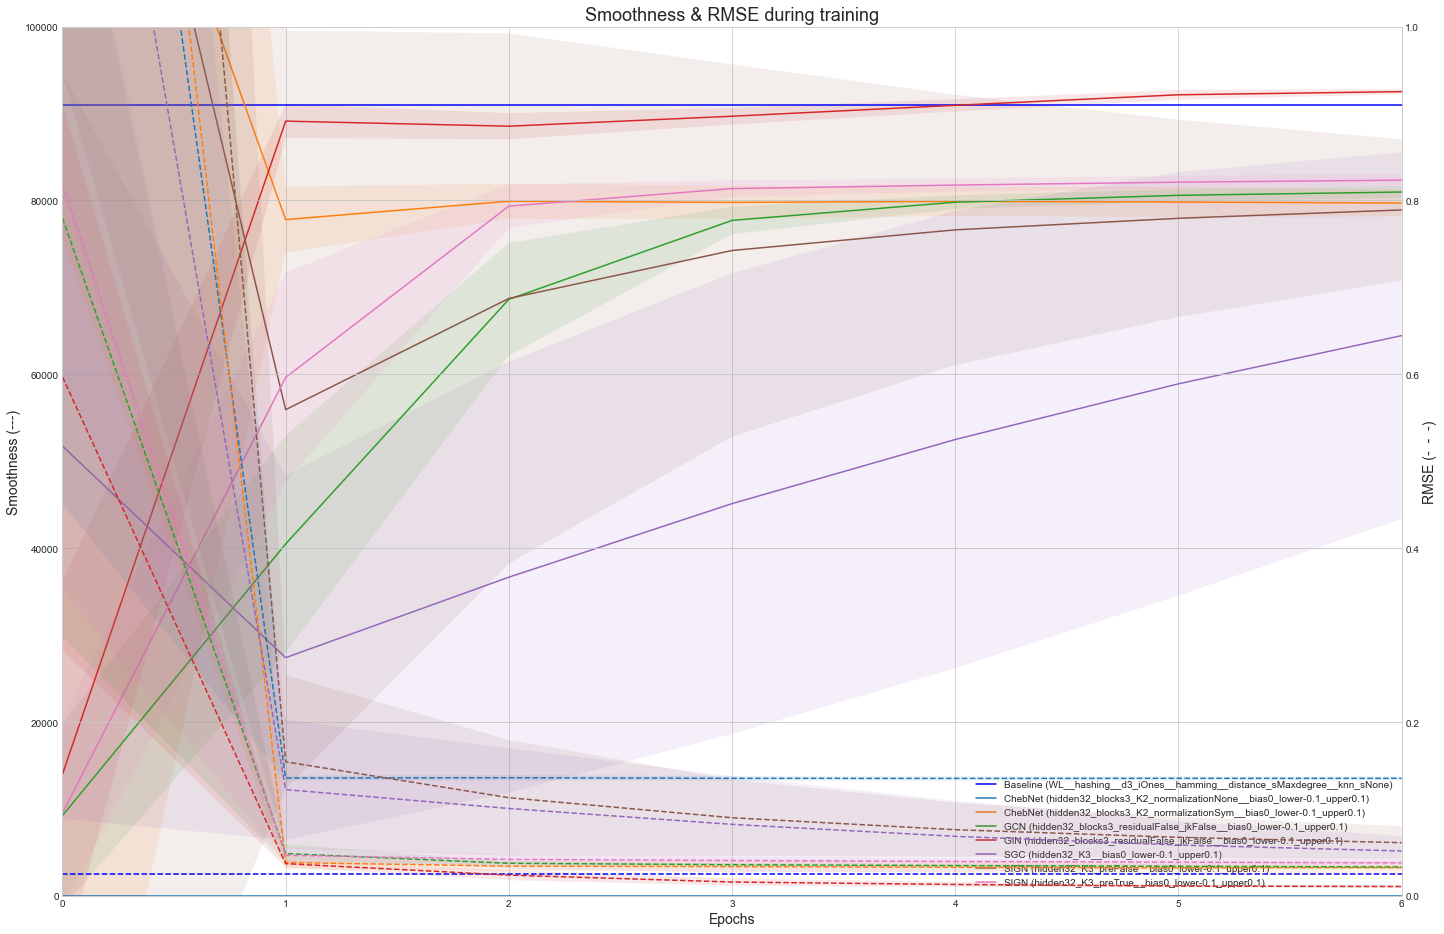

In [22]:
# Retrieve all model parameterizations
model_configs = smoothness_stats_avg.index.tolist()
# Retrieve all the column-split data
all_stats = getAllStats(smoothness_stats_avg)

# Create the figure and plot everything
fig, ax = plt.subplots(1, 1, figsize=(24, 16))
ax_twin = ax.twinx()


for i, model_config in enumerate(model_configs):
    plotSmoothnessRMSE(ax, ax_twin, all_stats, model_config)


print_info = f"""
Visualizing smoothness with the following configuration:

    \u2022 Teacher configuration used: \033[4mGIN (num1_hidden32_blocks3_residualFalse_jkTrue__bias0_lower-0.1_upper0.1)\033[0m
    \u2022 Distance matrix used: \033[4m{DIST_MATRIX}\033[0m


"""
print(print_info)
plt.show()

Take the *final* results and make a scatter plot.

In [17]:
baseline_configs = [x for x in smoothness_stats_avg.index.tolist() if x[0] == 'Baseline']
smoothness_stats_avg_final = smoothness_stats_avg.iloc[:, smoothness_stats_avg.columns.get_level_values(0) == '6']
smoothness_stats_avg_final.columns = smoothness_stats_avg_final.columns.droplevel(0)
# Since the baseline is not trained, substitute with the initial values
for baseline_config in baseline_configs:
    aux = smoothness_stats_avg.loc[baseline_config, smoothness_stats_avg.columns.get_level_values(0) == '0']
    aux.index = aux.index.droplevel(0)
    smoothness_stats_avg_final.loc[baseline_config] = aux

smoothness_stats_avg_final

/Users/berges/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/berges/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


mean_smoothness  \
model    model_config                                                          
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...     9.101816e+04   
ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_lo...     3.355817e-08   
         hidden32_blocks3_K2_normalizationSym__bias0_low...     7.971162e+04   
GCN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...     8.097292e+04   
GIN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...     9.251664e+04   
SGC      hidden32_K3__bias0_lower-0.1_upper0.1                  6.446365e+04   
SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1         7.891394e+04   
         hidden32_K3_preTrue__bias0_lower-0.1_upper0.1          8.233644e+04   

                                                             std_dev_smoothness  \
model    model_config                                                             
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...        0.000000e+00   
ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_lo...        4.214454e-08   
         hidden32_blocks3_K2_normalizationSym__bias0_low...        1.557102e+03   
GCN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...        6.811521e+02   
GIN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...        2.986624e+02   
SGC      hidden32_K3__bias0_lower-0.1_upper0.1                     2.107562e+04   
SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1            8.132287e+03   
         hidden32_K3_preTrue__bias0_lower-0.1_upper0.1             6.887131e+02   

                                                             mean_rmse  \
model    model_config                                                    
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...   0.025899   
ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_lo...   0.135634   
         hidden32_blocks3_K2_normalizationSym__bias0_low...   0.032997   
GCN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...   0.033683   
GIN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...   0.011230   
SGC      hidden32_K3__bias0_lower-0.1_upper0.1                0.052112   
SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1       0.061640   
         hidden32_K3_preTrue__bias0_lower-0.1_upper0.1        0.038465   

                                                             std_dev_rmse  
model    model_config                                                      
Baseline WL__hashing__d3_iOnes__hamming__distance_sMaxde...      0.000000  
ChebNet  hidden32_blocks3_K2_normalizationNone__bias0_lo...      0.002175  
         hidden32_blocks3_K2_normalizationSym__bias0_low...      0.007153  
GCN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...      0.001683  
GIN      hidden32_blocks3_residualFalse_jkFalse__bias0_l...      0.001442  
SGC      hidden32_K3__bias0_lower-0.1_upper0.1                   0.017111  
SIGN     hidden32_K3_preFalse__bias0_lower-0.1_upper0.1          0.019122  
         hidden32_K3_preTrue__bias0_lower-0.1_upper0.1           0.003278

/Users/berges/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


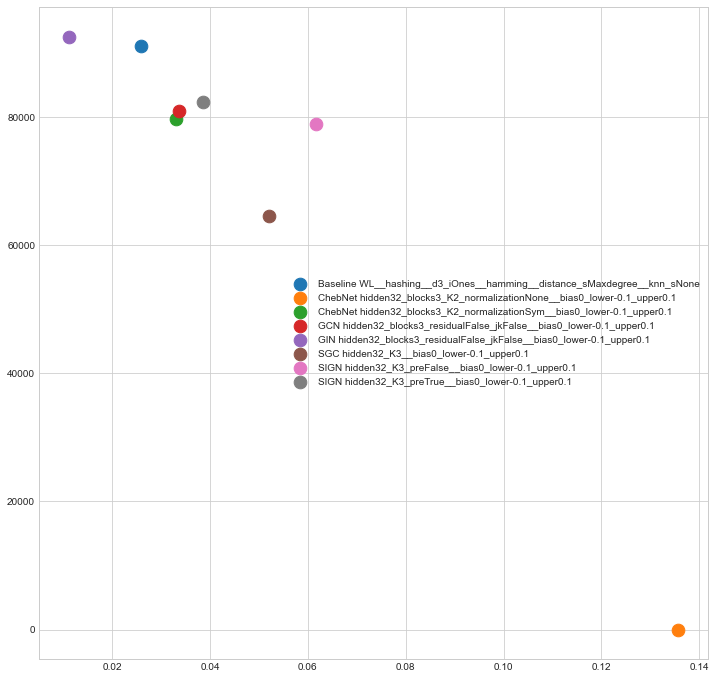

In [18]:
# Make a scatter plot with the results
smoothness_stats_avg_final['model_config'] = [x[0] + ' ' + x[1] for x in smoothness_stats_avg_final.index.tolist()]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

for i in range(len(smoothness_stats_avg_final)):
    x = smoothness_stats_avg_final['mean_rmse'].tolist()[i]
    y = smoothness_stats_avg_final['mean_smoothness'].tolist()[i]
    c = smoothness_stats_avg_final['model_config'].tolist()[i]
    ax.scatter(x, y, s=160, label=c)

ax.legend(loc=7)


plt.show()